# Using SCOTCH to integarte single-cell RNA-seq and ATAC-seq data of mouse brain cortex
***SNARE-seq(Chen-2019)***

## Import required python packages

In [53]:
import pandas as pd
import anndata as ad
import scanpy as sc
import numpy as np
from scotch import *

## Load datasets

In [54]:
rna = load_data("/slurm/home/yrd/fanlab/yangpenghui/SCOTCH/data/Chen-2019/rna.h5ad")
gam = load_data("/slurm/home/yrd/fanlab/yangpenghui/SCOTCH/data/Chen-2019/gam.h5ad")
atac = load_data("/slurm/home/yrd/fanlab/yangpenghui/SCOTCH/data/Chen-2019/atac.h5ad")

## Process datasets
SCOTCH uses a basic processing flow.  
**For gene expression and gene activity score data**, SCOTCH successively performed operations such as standardization and normalization, and performed Principal component analysis (PCA) to obtain a low-dimensional embedding representation.  
**For ATAC data**, we learn from Signac's process, use term frequency-inverse document frequency (TF-IDF) normalization, and use singular value decomposition (SVD) to obtain a low-dimensional embedding representation.  
Users can also use low-dimensional embedding representations processed by other tools (such as **harmony**) instead of using the results of conventional analysis processes. Just store the low-dimensional embedding representation into `anndata.obsm['reduction']`

### Process scRNA-seq dataset

/slurm/home/yrd/fanlab/yangpenghui/anaconda3/envs/yph/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Processing RNA data...
Identifying highly variable genes...


Trying to set attribute `.uns` of view, copying.


Normalizing total counts...
Applying log1p transformation...
Saving pre-log1p counts to a layer...
Scaling the data...
Performing PCA...
Calculating neighbors based on cosine metric...
Performing UMAP...


... storing 'domain' as categorical
... storing 'cell_type' as categorical


Processing completed.


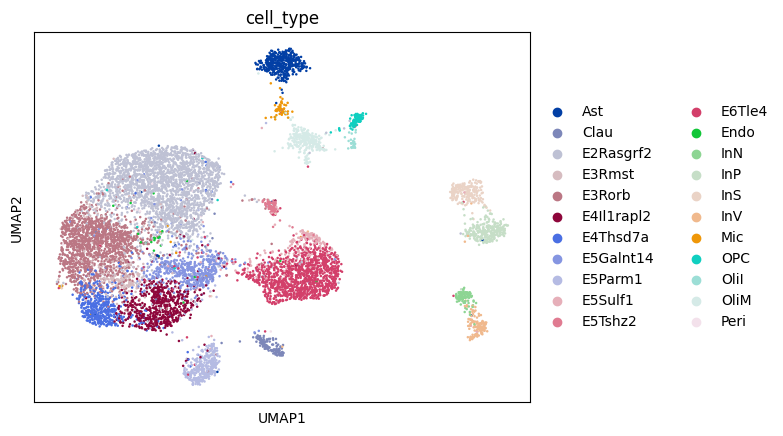

In [55]:
#Since the data comes from paired sequencing data, in order to avoid the impact of cell sorting on the results, the cell order was disrupted.
rna, atac = sort_datasets(rna, atac, suffix1="_RNA", suffix2="_ATAC")
gam = gam[atac.obs.index]
rna = shuffle_obs(rna)
gam = shuffle_obs(gam)

# Processing
rna = process_anndata(rna)
sc.pl.umap(rna, color="cell_type")

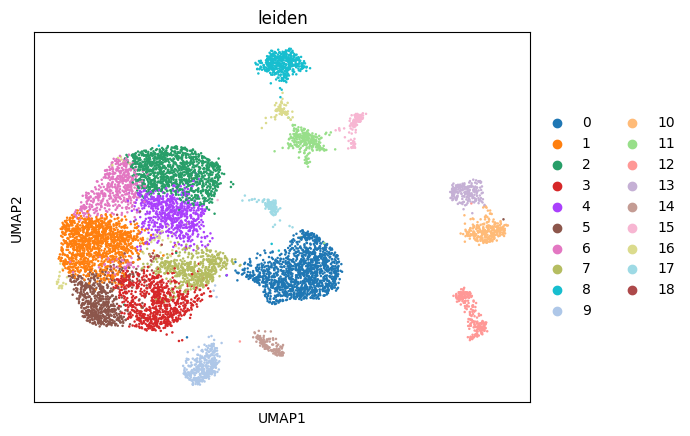

In [56]:
# Clustering
sc.tl.leiden(rna,resolution = 1)
sc.pl.umap(rna, color="leiden")

### Process scATAC-seq dataset

Processing ATAC data...
Running LSI...
Calculating neighbors based on cosine metric using X_lsi...
Performing UMAP...
Processing completed.


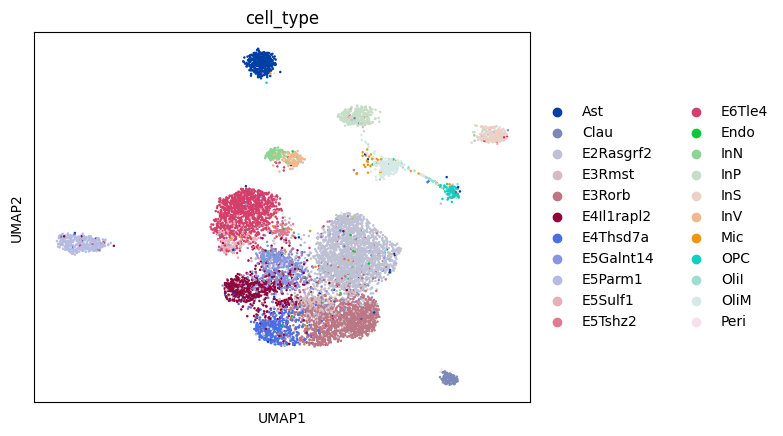

In [57]:
# Processing
atac = process_anndata(atac,mode='atac')
sc.pl.umap(atac, color="cell_type")

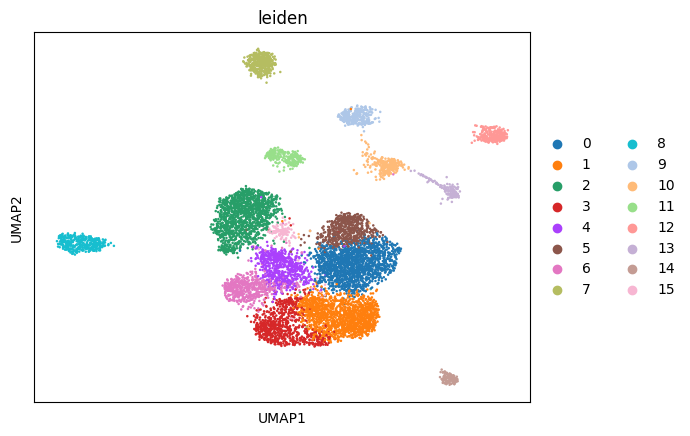

In [58]:
# Clustering
sc.tl.leiden(atac,resolution = 1)
sc.pl.umap(atac, color="leiden")

### Process scATAC-seq dataset (gene activity score)

In [59]:
gam = process_anndata(gam,pca=False,neighbors=False,umap=False)

Processing RNA data...
Identifying highly variable genes...


Trying to set attribute `.uns` of view, copying.


Normalizing total counts...
Applying log1p transformation...
Saving pre-log1p counts to a layer...
Scaling the data...
Processing completed.


In [60]:
rna, atac = sort_datasets(rna, atac, suffix1="_RNA", suffix2="_ATAC")
gam = gam[atac.obs.index]
gam.obs['leiden'] = atac.obs['leiden']

/slurm/home/yrd/fanlab/yangpenghui/anaconda3/envs/yph/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/slurm/home/yrd/fanlab/yangpenghui/anaconda3/envs/yph/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
Trying to set attribute `.obs` of view, copying.


In [ ]:
# Store low-dimensional embedding representation for subsequent calls
rna.obsm['reduction'] = rna.obsm['X_pca']
gam.obsm['reduction'] = atac.obsm['X_lsi']

## Tansfer labels
By default, SCOTCH uses the gene with the greatest difference between cell populations as the marker gene for the tranfer of cell labels.
At this time, the label of the cell population can be the label of Leiden clustering obtained in the preprocessing, or the label of the cell type defined by the user. Specifically, it can be specified through the two parameters of `marker1_by` and `marker2_by`.  
SCOTCH will calculate the average gene expression and gene activity score of the marker gene in the cell population, and calculate the transfer score of labels between the two sets of data.

In [61]:
# Calculate marker genes
adata1,adata2 = find_marker(rna,gam,min_cells=0,top_marker_num=10)

Finding marker genes...
Number of common genes: 18814
Calculating marker genes based on 'leiden' for adata1...


/slurm/home/yrd/fanlab/yangpenghui/anaconda3/envs/yph/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/slurm/home/yrd/fanlab/yangpenghui/anaconda3/envs/yph/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
Trying to set attribute `.uns` of view, copying.
/slurm/home/yrd/fanlab/yangpenghui/anaconda3/envs/yph/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/slurm/home/yrd/fanlab/yangpenghui/anaconda3/envs/yph/lib/python3.8/site-packages/scanpy/tools/_rank_genes_

Calculating marker genes based on 'leiden' for adata2...


... storing 'domain' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type' as categorical


Marker gene calculation completed.


/slurm/home/yrd/fanlab/yangpenghui/anaconda3/envs/yph/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/slurm/home/yrd/fanlab/yangpenghui/anaconda3/envs/yph/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/slurm/home/yrd/fanlab/yangpenghui/anaconda3/envs/yph/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/slurm/home/yrd/fanlab/yangpenghui/anaconda3/envs/yph/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/slurm/home/yrd/fanlab/yangpenghui/anaconda3/envs/yph/lib/python3.8/site-packages/scanpy/tools/_

In [62]:
# Tansfering
adata1, adata2, transfer_df = scotch_transfer( test_data = adata1,reference_data = adata2,test_avg_by='leiden',reference_avg_by='leiden',reg=1)

/slurm/home/yrd/fanlab/yangpenghui/anaconda3/envs/yph/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Performing label transfer...
Calculating average expression...


/slurm/home/yrd/fanlab/yangpenghui/anaconda3/envs/yph/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/slurm/home/yrd/fanlab/yangpenghui/anaconda3/envs/yph/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
Trying to set attribute `.obs` of view, copying.


Computing correlation matrix...
Performing unbalanced optimal transport...
Applying cutoff to transfer probabilities and mapping labels...
Label transfer completed.


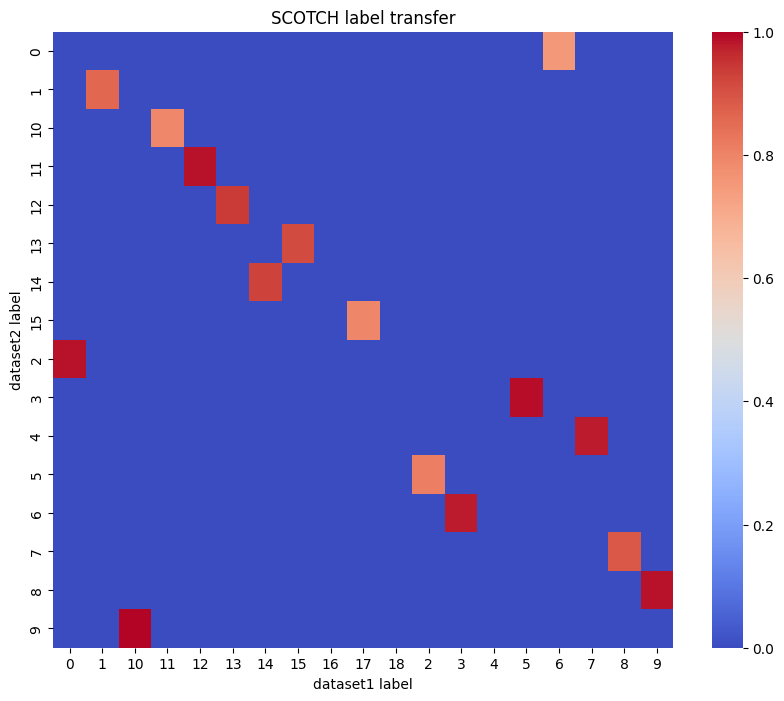

In [63]:
plot_heatmap(transfer_df)

## Cell alignment calculates matching relationships
SCOTCH combines the K-Nearest Neighbors（KNN） algorithm and partial optimal transport (OT) algorithm to compute the matching relationships between similar cells across modalities. Initially, cell labels are determined through label transfer. SCOTCH then extracts cross-modal data for cell clusters with same labels. It constructs modality-specific KNN networks based on low-dimensional embeddings and utilizes the partial OT algorithm to calculate the probability of cross-modal matches between cells.

In [64]:
adata1, adata2 = intersect_datasets(data1 = adata1, data2 = adata2)

/slurm/home/yrd/fanlab/yangpenghui/anaconda3/envs/yph/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/slurm/home/yrd/fanlab/yangpenghui/anaconda3/envs/yph/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [65]:
result = scotch_alignment(adata1, adata2)

Performing SCOTCH alignment...
Processing cell type 1/16: 8
mass : 0.9726027397260274
Constructing connectivity...
k = 10
Running OT...
Processing cell type 2/16: 1
mass : 0.8391188251001335
Constructing connectivity...
k = 10


/slurm/home/yrd/fanlab/yangpenghui/anaconda3/envs/yph/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Running OT...
Processing cell type 3/16: 10
mass : 0.9885496183206107
Constructing connectivity...
k = 10


/slurm/home/yrd/fanlab/yangpenghui/anaconda3/envs/yph/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Running OT...
Processing cell type 4/16: 9
mass : 0.9787985865724381
Constructing connectivity...
k = 10


/slurm/home/yrd/fanlab/yangpenghui/anaconda3/envs/yph/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Running OT...
Processing cell type 5/16: 4
mass : 0.8134796238244514
Constructing connectivity...
k = 10


/slurm/home/yrd/fanlab/yangpenghui/anaconda3/envs/yph/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Running OT...
Processing cell type 6/16: 5
mass : 0.5357450473729544
Constructing connectivity...
k = 10


/slurm/home/yrd/fanlab/yangpenghui/anaconda3/envs/yph/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Running OT...
Processing cell type 7/16: 2
mass : 0.96996336996337
Constructing connectivity...
k = 10


/slurm/home/yrd/fanlab/yangpenghui/anaconda3/envs/yph/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Running OT...
Processing cell type 8/16: 13
mass : 0.8289473684210527
Constructing connectivity...
k = 10


/slurm/home/yrd/fanlab/yangpenghui/anaconda3/envs/yph/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Running OT...
Processing cell type 9/16: 7
mass : 0.9159090909090909
Constructing connectivity...
k = 10


/slurm/home/yrd/fanlab/yangpenghui/anaconda3/envs/yph/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Running OT...
Processing cell type 10/16: 3
mass : 0.8405797101449275
Constructing connectivity...
k = 10


/slurm/home/yrd/fanlab/yangpenghui/anaconda3/envs/yph/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Running OT...
Processing cell type 11/16: 6
mass : 0.6974358974358974
Constructing connectivity...
k = 10


/slurm/home/yrd/fanlab/yangpenghui/anaconda3/envs/yph/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Running OT...
Processing cell type 12/16: 0
mass : 0.33436341161928307
Constructing connectivity...
k = 10


/slurm/home/yrd/fanlab/yangpenghui/anaconda3/envs/yph/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Running OT...
Processing cell type 13/16: 14
mass : 0.9694656488549618
Constructing connectivity...
k = 10


/slurm/home/yrd/fanlab/yangpenghui/anaconda3/envs/yph/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Running OT...
Processing cell type 14/16: 15
mass : 0.9098360655737705
Constructing connectivity...
k = 10


/slurm/home/yrd/fanlab/yangpenghui/anaconda3/envs/yph/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Running OT...
Processing cell type 15/16: 11
mass : 0.930327868852459
Constructing connectivity...
k = 10


/slurm/home/yrd/fanlab/yangpenghui/anaconda3/envs/yph/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Running OT...
Processing cell type 16/16: 12
mass : 0.8820960698689956
Constructing connectivity...
k = 10


/slurm/home/yrd/fanlab/yangpenghui/anaconda3/envs/yph/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Running OT...
SCOTCH alignment completed.


In [66]:
(result["cell_type1"].astype('object') == result["cell_type2"].astype('object')).sum()/len(result)

0.7270123605667772

## Data integration using matching relationships
Based on the obtained cell cross-modal matching relationship, SCOTCH uses the Canonical correlation analysis (CCA) algorithm to directly integrate the low-dimensional embedding representation of the modality.  
*Special note: Due to the random disruption of the cell order, there are slight deviations in the calculated modal low-dimensional embedding representation, resulting in slight differences between the tourial and the article, but this does not affect the conclusion. The tight hierarchical connections between cortical cells can still be seen from the figure.*

Integrating and concatenating AnnData objects...


/slurm/home/yrd/fanlab/yangpenghui/anaconda3/envs/yph/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/slurm/home/yrd/fanlab/yangpenghui/anaconda3/envs/yph/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Integration and concatenation completed.


... storing 'domain' as categorical
... storing 'leiden' as categorical


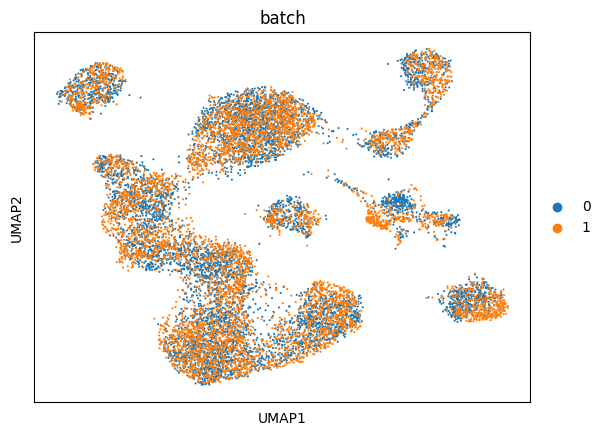

In [71]:
adata1, adata2, adata_integrated = integrate_adata(adata1=adata1, adata2=adata2, df=result, n_components = 30, max_iter = 1000,cca_components = 10)
sc.pp.neighbors(adata_integrated, use_rep="integrated", metric="cosine")
sc.tl.umap(adata_integrated)
sc.pl.umap(adata_integrated, color="batch")

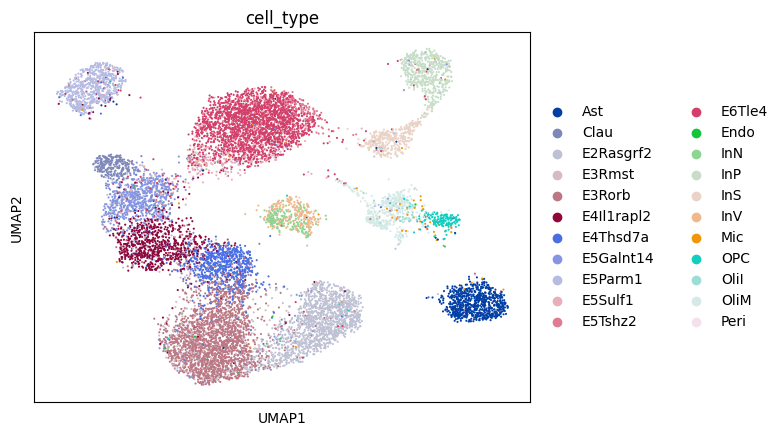

In [72]:
sc.pl.umap(adata_integrated, color="cell_type")